In [0]:
import pandas as pd

url = 'https://raw.githubusercontent.com/MadanAravind/Weather-Forecast-using-NN/master/weather16-18.csv'

In [0]:
features = ["time", "temperature", "humidity", "dewPoint", "pressure", "windSpeed"]
df1 = pd.read_csv(url)
records = df1.values.tolist()

df = pd.DataFrame(records, columns=features).set_index('time') 

In [0]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 25774 entries, 31-12-2015 19:30 to 31-12-2018 17:30
Data columns (total 5 columns):
temperature    25774 non-null float64
humidity       25774 non-null float64
dewPoint       25774 non-null float64
pressure       25774 non-null float64
windSpeed      25774 non-null float64
dtypes: float64(5)
memory usage: 1.2+ MB


In [0]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
temperature,25774.0,29.224220,3.137638,20.28,27.04,29.13,31.07,41.32
humidity,25774.0,0.722593,0.128312,0.27,0.63,0.74,0.82,1.00
dewPoint,25774.0,23.398512,2.317875,12.89,21.98,23.83,25.12,28.30
pressure,25774.0,23.398512,2.317875,12.89,21.98,23.83,25.12,28.30
windSpeed,25774.0,2.295289,1.416517,0.00,1.22,2.07,3.10,36.00


In [0]:
X = df[[col for col in df.columns if col != 'temperature']]

y = df['temperature']  

In [0]:
import numpy as np  
import tensorflow as tf  
from sklearn.metrics import explained_variance_score,mean_absolute_error,median_absolute_error
from sklearn.model_selection import train_test_split  

In [0]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.2, random_state=23)  

In [0]:
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=23)

X_train.shape, X_test.shape, X_val.shape  
print("Training instances   {}, Training features   {}".format(X_train.shape[0], X_train.shape[1]))  
print("Validation instances {}, Validation features {}".format(X_val.shape[0], X_val.shape[1]))  
print("Testing instances    {}, Testing features    {}".format(X_test.shape[0], X_test.shape[1])) 

Training instances   20619, Training features   4
Validation instances 2578, Validation features 4
Testing instances    2577, Testing features    4


In [0]:
feature_cols = [tf.feature_column.numeric_column(col) for col in X.columns] 

In [0]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols,  
                                      hidden_units=[50, 50],
                                      model_dir='tf_wx_model')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tf_wx_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f82e67119e8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=400):  
    return tf.estimator.inputs.pandas_input_fn(x=X,
                                               y=y,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)

In [0]:
evaluations = []  
STEPS = 400  
for i in range(100):  
    regressor.train(input_fn=wx_input_fn(X_train, y=y_train), steps=STEPS)
    evaluations.append(regressor.evaluate(input_fn=wx_input_fn(X_val,
                                                               y_val,
                                                               num_epochs=1,
                                                               shuffle=False)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-100000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 100000 into tf_wx_model/model.ckpt.
INFO:tensorflow:loss = 3.0588913, step = 100001
INFO:tensorflow:global_step/sec: 241.484
INFO:tensorflow:loss = 507.8096, step = 100101 (0.417 sec)
INFO:tensorflow:global_step/sec: 311.077
INFO:tensorflow:loss = 390.9577, step = 100201 (0.320 sec)
INFO:tensorflow:global_step/sec: 302.754
INFO:tensorflow:loss = 429.7063, step = 100301 (0.330 sec)
INFO:tensorflow:Saving checkpoints for 100400 into tf_wx_model/model.ckpt.
INFO:tensorflow:Loss for final step: 265.5803.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-14T06:49:58Z
INFO:tensorfl

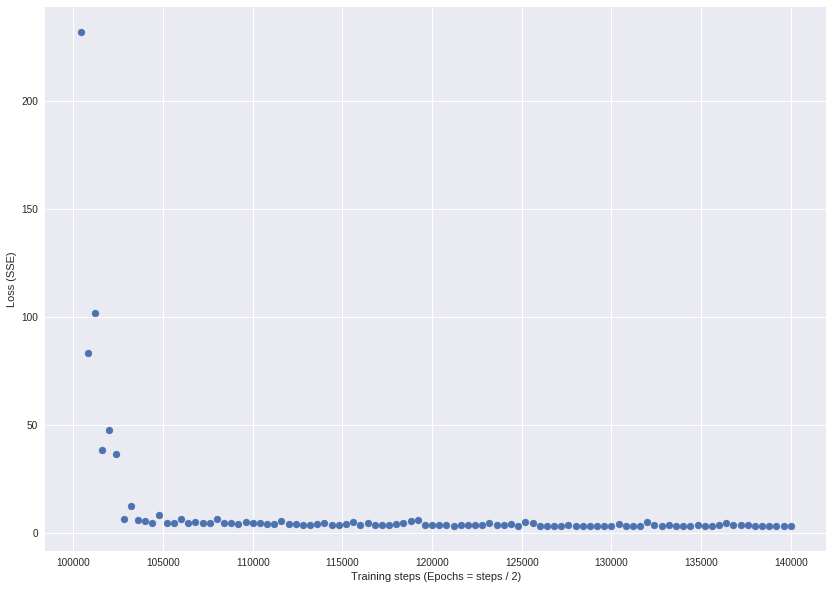

In [0]:
import matplotlib.pyplot as plt  
%matplotlib inline

# manually set the parameters of the figure to and appropriate size
plt.rcParams['figure.figsize'] = [14, 10]

loss_values = [ev['loss'] for ev in evaluations]  
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)  
plt.xlabel('Training steps (Epochs = steps / 2)')  
plt.ylabel('Loss (SSE)')  
plt.show()  

In [0]:
pred = regressor.predict(input_fn=wx_input_fn(X_test,  
                                              num_epochs=1,
                                              shuffle=False))
predictions = np.array([p['predictions'][0] for p in pred])

print("The Explained Variance: %.2f" % explained_variance_score(  
                                            y_test, predictions))  
print("The Mean Absolute Error: %.2f degrees Celcius" % mean_absolute_error(  
                                            y_test, predictions))  
print("The Median Absolute Error: %.2f degrees Celcius" % median_absolute_error(  
                                            y_test, predictions))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-100000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
The Explained Variance: 1.00
The Mean Absolute Error: 0.07 degrees Celcius
The Median Absolute Error: 0.06 degrees Celcius


In [0]:
prediction = pd.DataFrame(predictions, columns=['predictions']).to_csv('prediction.csv')